In [1]:
import tensorflow as tf
from tensorflow.keras import Input, Model, layers
import numpy as np 
import matplotlib.pyplot as plt
import json
import os 
from PIL import Image

In [77]:
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

# TEST_FILENAMES = '../../datasets/google_split_tfrec/test.tfrec' 
# TEST_FILENAMES = '../../datasets/mit_split_tfrec/test.tfrec' 
# IDs = ['03183','01877','01326','03140','02091','02301','02240','00382','02833','02078']
ID = '02078'
TEST_FILENAMES = '../../datasets/Users_MIT_tfrec/'+ ID +'.tfrec' 

BATCH_SIZE = 1

SEED = tf.Variable(256)

In [4]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "device": tf.io.FixedLenFeature([], tf.string),
        "screen_h": tf.io.FixedLenFeature([], tf.int64),
        "screen_w": tf.io.FixedLenFeature([], tf.int64),
        "face_valid": tf.io.FixedLenFeature([], tf.int64),
        "face_x": tf.io.FixedLenFeature([], tf.int64),
        "face_y": tf.io.FixedLenFeature([], tf.int64),
        "face_w": tf.io.FixedLenFeature([], tf.int64),
        "face_h": tf.io.FixedLenFeature([], tf.int64),
        "leye_x": tf.io.FixedLenFeature([], tf.int64),
        "leye_y": tf.io.FixedLenFeature([], tf.int64),
        "leye_w": tf.io.FixedLenFeature([], tf.int64),
        "leye_h": tf.io.FixedLenFeature([], tf.int64),
        "reye_x": tf.io.FixedLenFeature([], tf.int64),
        "reye_y": tf.io.FixedLenFeature([], tf.int64),
        "reye_w": tf.io.FixedLenFeature([], tf.int64),
        "reye_h": tf.io.FixedLenFeature([], tf.int64),
        "dot_xcam": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_cam": tf.io.FixedLenFeature([], tf.float32),
        "dot_x_pix": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_pix": tf.io.FixedLenFeature([], tf.float32),
        "reye_x1": tf.io.FixedLenFeature([], tf.int64),
        "reye_y1": tf.io.FixedLenFeature([], tf.int64),
        "reye_x2": tf.io.FixedLenFeature([], tf.int64),
        "reye_y2": tf.io.FixedLenFeature([], tf.int64),
        "leye_x1": tf.io.FixedLenFeature([], tf.int64),
        "leye_y1": tf.io.FixedLenFeature([], tf.int64),
        "leye_x2": tf.io.FixedLenFeature([], tf.int64),
        "leye_y2": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example


def augmentation(image, training = True):
    if training:
        aug = tf.keras.Sequential([
                layers.Resizing(128+10, 128+10),
                layers.RandomCrop(128, 128, 256),
                layers.Rescaling(1./255),
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
        
    else:
        aug = tf.keras.Sequential([
                layers.Resizing(128, 128),
                layers.Rescaling(1./255),
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
    
    image = aug(image)
    
    return image

def prepare_eval_sample(features):
    img_feat = features['image']

    h = tf.shape(img_feat)[0]
    w = tf.shape(img_feat)[1]

    w = tf.cast(w, tf.int64)
    h = tf.cast(h, tf.int64)

    screen_w, screen_h = features['screen_w'], features['screen_h']

    kps = [features['leye_x1']/w, features['leye_y1']/h, features['leye_x2']/w, features['leye_y2']/h,
           features['reye_x1']/w, features['reye_y1']/h, features['reye_x2']/w, features['reye_y2']/h]
    # kps has type float64

    lx, ly, lw, lh = int(features['leye_x']), int(features['leye_y']), int(features['leye_w']), int(features['leye_h'])
    rx, ry, rw, rh = int(features['reye_x']), int(features['reye_y']), int(features['reye_w']), int(features['reye_h'])

    lx = tf.clip_by_value(lx, 0, int(w)-lw)
    ly = tf.clip_by_value(ly, 0, int(h)-lh)

    rx = tf.clip_by_value(rx, 0, int(w)-rw)
    ry = tf.clip_by_value(ry, 0, int(h)-rh)

    l_eye = tf.image.crop_to_bounding_box(img_feat, ly, lx, lh, lw)
    r_eye = tf.image.crop_to_bounding_box(img_feat, ry, rx, rh, rw)

    l_eye = tf.image.flip_left_right(l_eye)

    l_eye = augmentation(l_eye, False)
    r_eye = augmentation(r_eye, False)

    y = [features['dot_xcam'], features['dot_y_cam']]
    # y has type float32
    
    path = features['path']

    return (l_eye, r_eye, kps), y, path

    # return (l_eye, r_eye, kps), y



def get_eval_dataset(filenames, batch_size):
    option_no_order = tf.data.Options()
    option_no_order.deterministic = False  # disable order, increase speed
    
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .with_options(option_no_order)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTO)
        .map(prepare_eval_sample, num_parallel_calls=AUTO)
        .batch(batch_size)
    )
    
    dataset_len = sum(1 for _ in tf.data.TFRecordDataset(filenames))
    print(f"No. of samples: {dataset_len}")
    
    return dataset

In [78]:
test_dataset = get_eval_dataset(TEST_FILENAMES, BATCH_SIZE)

No. of samples: 786


# Model

In [6]:
new_model = tf.keras.models.load_model('../../checkpoints/new_mod/mit/rlrop100_3/epoch-74-vl-2.877.ckpt') 
# new_model = tf.keras.models.load_model('../../checkpoints/new_mod/gs/rlrop100/epoch-99-vl-2.371.ckpt')

In [7]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                              

In [8]:
def euc(a, b):
    return np.sqrt(np.sum(np.square(a - b), axis=1))

In [9]:
def tensor2str(path):
    path_np = np.array(path)
    path_str = np.array_str(path_np)
    result_1 = path_str.split('images/', 1)[1]
    image_id = result_1.split('.jpg', 1)[0]
    user_id = image_id.split('_')[0]
    return user_id

# Get preds

In [79]:
preds, gt = [], []
for x_test,y_test, path in test_dataset:
    pred = new_model.predict(x_test)
    preds.extend(pred)
    gt.extend(y_test)
    # print(path)
    # user_id = tensor2str(path)
    # if user_id == '02138':
    #     pred = new_model.predict(x_test)
    #     preds.extend(pred)
    #     gt.extend(y_test)

1/1 [==============================] - 0s 57ms/step


## Results

In [80]:
preds = np.array(preds)
pts = np.unique(gt, axis=0)
gt = np.array(gt)
dist = euc(preds, gt)
print("Mean Euclidean Distance: ", dist.mean())

Mean Euclidean Distance:  1.2194426


# Plots

In [68]:
import colorsys
import random
def get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

c = get_colors(len(pts))
random.shuffle(c)

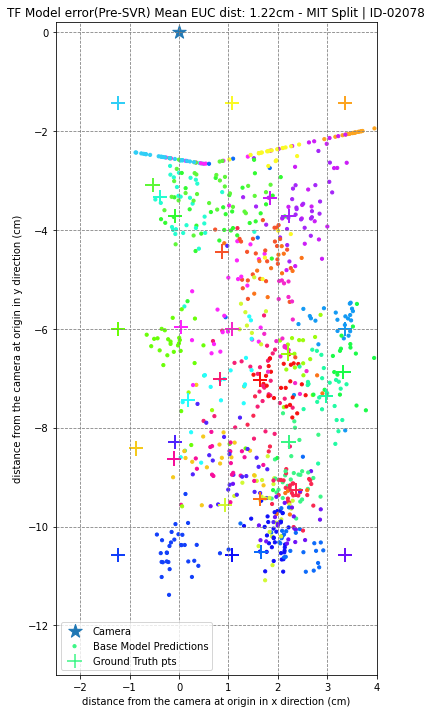

In [81]:
cols = np.zeros((len(gt),3))
for i in range(len(pts)):
    cols[np.where(np.all(gt==pts[i],axis=1))] = c[i]
    
plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.legend(['Camera', 'Base Model Predictions','Ground Truth pts'], loc='lower left');
plt.title("TF Model error(Pre-SVR) Mean EUC dist: 1.22cm - MIT Split | ID-02078")
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)
plt.savefig('../../plots/tf-mit-2078-basemodel.png')

In [41]:
def plot_pts(gt, preds, pts, c, title, save_loc, cent=False):
    
    cols = np.zeros((len(gt),3))
    cents = np.zeros_like(preds)
    
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i], axis=1))] = c[i]
        if(cent):
            cents[np.where(np.all(gt==pts[i], axis=1))] = np.mean(preds[np.where(np.all(gt==pts[i], axis=1))], axis=0)
    
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.grid(color='gray', linestyle='dashed')
    plt.scatter(0, 0, marker='*', s=200)
    # plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
    plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
    if(cent):
        plt.scatter(cents[:,0], cents[:,1], c=cols, marker='1',s=100)
    plt.xlabel('distance from the camera at origin in x direction (cm)')
    plt.ylabel('distance from the camera at origin in y direction (cm)')
    plt.legend(['Camera', 'Ground Truth pts', 'Base Model Predictions Centroids'], loc='lower left');
    plt.axis('scaled')
    plt.xlim(-2.5, 4)
    plt.ylim(-13, 0.2)
    
    plt.savefig(save_loc)   

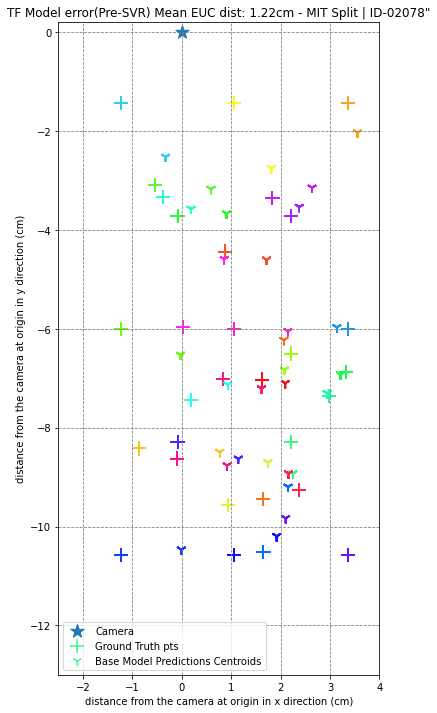

In [82]:
plot_pts(gt=gt, preds=preds, pts=pts, c=c, title='TF Model error(Pre-SVR) Mean EUC dist: 1.22cm - MIT Split | ID-02078"', save_loc='../../plots/tf-mit-2078-basemodel-cent.png', cent=True)

# SVR

In [89]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

# To find mean of an integer list
def Average(lst):
    return sum(lst) / len(lst)

#This is used to remove spaces from a string
def remove(string):
    return string.replace(" ", "")


# Euclidean distance is defined
def euc(a, b):
    dist = np.sqrt(np.sum(np.square(a - b), axis=1))
    mean = dist.mean()
    return mean


csv_path = '../../CSVs/MIT_unique/unique30_' + '03140' + '.csv'
# csv_path = '../../CSVs/google_all/' + ID + '.csv'

# csv_path = '../../CSVs/MIT_all/'+ ID + '.csv'

Model_1=pd.read_csv(csv_path)

# print(Model_1.shape)

## SHUFFLE & SPLIT SIZE
train, test = train_test_split(Model_1, test_size=0.334,random_state=42, shuffle=False)

a_train=train['Penultimate_Output']
b_train=train['GT_Value']
a_test=test['Penultimate_Output']
b_test=test['GT_Value']

# y_train.extend(b_train)
# y_test.extend(b_test)

for i in range(0,len(a_train)):
    lis=[]
    a_train.iloc[i]=remove(a_train.iloc[i])
    x=a_train.iloc[i]
    a=x.split(',')
    x=a[0]
    x=x[9:]
    x1=a[1]

    x2=a[2]

    x3=a[3]
    x3=x3[0:-2]

    lis.append(float(x))
    lis.append(float(x1))
    lis.append(float(x2))
    lis.append(float(x3))
    a_train.iloc[i]=lis

for i in range(0,len(a_test)):
    lis=[]
    a_test.iloc[i]=remove(a_test.iloc[i])
    x=a_test.iloc[i]
    a=x.split(',')
    x=a[0]
    x=x[9:]
    x1=a[1]

    x2=a[2]

    x3=a[3]
    x3=x3[0:-2]

    lis.append(float(x))
    lis.append(float(x1))
    lis.append(float(x2))
    lis.append(float(x3))
    a_test.iloc[i]=lis
for i in range(0,len(b_train)):
    lis=[]
    x=b_train.iloc[i]
    a=x.split(',')
    x1=a[0]
    x1=x1[9:]
    x2=a[1]
    x2=x2[0:-2]
    lis.append(float(x1))
    lis.append(float(x2))
    b_train.iloc[i]=lis
for i in range(0,len(b_test)):
    lis=[]
    x=b_test.iloc[i]
    a=x.split(',')
    x1=a[0]
    x1=x1[9:]
    x2=a[1]
    x2=x2[0:-2]
    lis.append(float(x1))
    lis.append(float(x2))
    b_test.iloc[i]=lis
for i in range(0,len(a_train)):
    a_train.iloc[i]=np.array(a_train.iloc[i])

for i in range(0,len(b_train)):
    b_train.iloc[i]=np.array(b_train.iloc[i])

a_train = a_train.apply(pd.Series)

b_train = b_train.apply(pd.Series)

reg = MultiOutputRegressor(SVR())

parameters = {'estimator__C': [20],  
              'estimator__gamma': [0.06], 
              'estimator__kernel': ['rbf'],
             'estimator__epsilon':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]}  
custom_scorer = make_scorer(euc, greater_is_better=False)

## Applying grid search to the dataset
grid_reg = GridSearchCV(estimator=reg,
                      param_grid=parameters,
                      scoring=custom_scorer,
                        cv=3,
                      verbose=1)
grid_reg.fit(a_train,b_train)

best_para = grid_reg.best_params_#Finding the best parameter
epsilon_SVR=best_para['estimator__epsilon']#Extracting epsilon value which has the lowest EUC

# print(best_para)

## Converting test set into panda series
for i in range(0,len(a_test)):
    a_test.iloc[i]=np.array(a_test.iloc[i])
for i in range(0,len(b_test)):
    b_test.iloc[i]=np.array(b_test.iloc[i])


a_test = a_test.apply(pd.Series)
b_test = b_test.apply(pd.Series)
reg = MultiOutputRegressor(SVR(C=20,epsilon=epsilon_SVR,gamma=0.06,kernel='rbf'))

## Fitting the Model
reg.fit(a_train,b_train)

y_pred = reg.predict(a_test)

MED=euc(y_pred,b_test)

print(MED)


Fitting 3 folds for each of 46 candidates, totalling 138 fits
1.582466036528894


In [90]:
b_test2 = b_test.to_numpy()
pts2 = np.unique(b_test2, axis=0)

## Plots

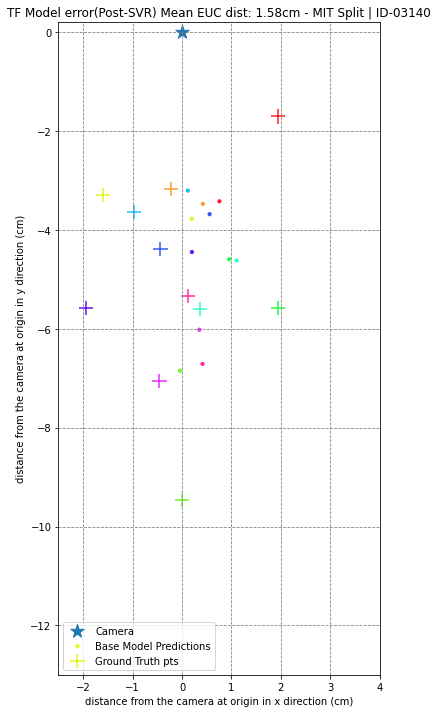

In [91]:
c2 = get_colors(len(pts2))
random.shuffle(c2)

cols2 = np.zeros((len(b_test2),3))
for i in range(len(pts2)):
    cols2[np.where(np.all(b_test2==pts2[i],axis=1))] = c2[i]


plt.figure(figsize=(12,12))
plt.grid(color='gray', linestyle='dashed')
plt.scatter(0, 0, marker='*', s=200)
plt.scatter(y_pred[:,0], y_pred[:,1], c=cols2, s=10)
plt.scatter(b_test2[:,0], b_test2[:,1], c=cols2, marker='+', s=200)
plt.xlabel('distance from the camera at origin in x direction (cm)')
plt.ylabel('distance from the camera at origin in y direction (cm)')
plt.legend(['Camera', 'Base Model Predictions','Ground Truth pts'], loc='lower left');
plt.title("TF Model error(Post-SVR) Mean EUC dist: 1.58cm - MIT Split | ID-03140")
plt.axis('scaled')
plt.xlim(-2.5, 4)
plt.ylim(-13, 0.2)
plt.savefig('../../plots/tf-mit-svr-3140-basemodel.png')

In [43]:
def plot_pts2(gt, preds, pts, c, title, save_loc, cent=False):
    
    cols = np.zeros((len(gt),3))
    cents = np.zeros_like(preds)
    
    for i in range(len(pts)):
        cols[np.where(np.all(gt==pts[i], axis=1))] = c[i]
        if(cent):
            cents[np.where(np.all(gt==pts[i], axis=1))] = np.mean(preds[np.where(np.all(gt==pts[i], axis=1))], axis=0)
    
    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.grid(color='gray', linestyle='dashed')
    plt.scatter(0, 0, marker='*', s=200)
    # plt.scatter(preds[:,0], preds[:,1], c=cols, s=10)
    plt.scatter(gt[:,0], gt[:,1], c=cols, marker='+', s=200)
    if(cent):
        plt.scatter(cents[:,0], cents[:,1], c=cols, marker='1',s=100)
    plt.xlabel('distance from the camera at origin in x direction (cm)')
    plt.ylabel('distance from the camera at origin in y direction (cm)')
    plt.legend(['Camera', 'Ground Truth pts', 'Base Model Predictions Centroids'], loc='lower left');
    plt.axis('scaled')
    plt.xlim(-2.5, 4)
    plt.ylim(-13, 0.2)
    
    plt.savefig(save_loc)

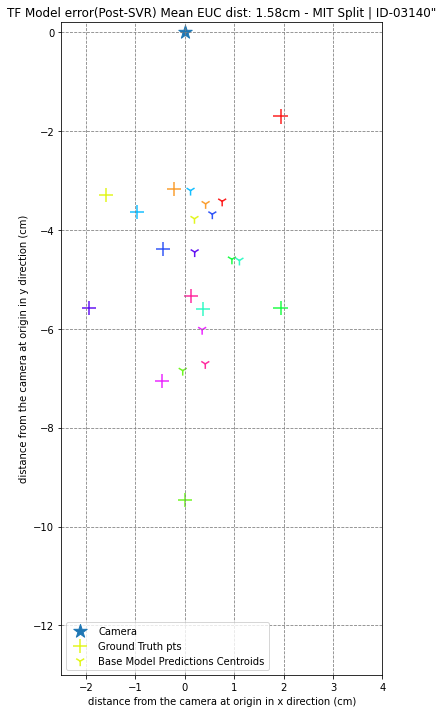

In [92]:
plot_pts(gt=b_test2, preds=y_pred, pts=pts2, c=c2, title='TF Model error(Post-SVR) Mean EUC dist: 1.58cm - MIT Split | ID-03140"', save_loc='../../plots/tf-mit-svr-3140-basemodel-cent.png', cent=True)

# Count of userid and frames per id

In [82]:
# preds, gt = [], []
count = []
user_ids = []
for x_test,y_test, path in test_dataset:
    user_id = tensor2str(path)
    if user_id not in user_ids:
        user_ids.append(user_id)
        count.append(0)
        

    if user_id in user_ids:
        i = user_ids.index(user_id)
        count[i] = count[i]+1

    
len(count), len(user_ids)

(1233, 1233)

In [84]:
user_count = {user_ids[i]:count[i] for i in range(len(user_ids))}

### Variables

In [66]:
for id in user_ids:
    if str(id)=='00469':
        print(user_ids.index(id))
        break

1111


In [68]:
count[1111]

12

In [48]:
count = sorted(count, reverse=True) 
user_ids = sorted(user_ids, reverse=True) 

In [ ]:
count[:10], user_ids[:10]

In [55]:
count.index(167)

1

In [59]:
user_ids[1]

'03502'